In [8]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")
sns.set_style("whitegrid")

from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GroupKFold, cross_validate, cross_val_predict
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import GradientBoostingRegressor
import joblib

from src.config import (
    MASTER_DF_FILE,
    RANDOM_SEED,
    MODELS_DIR,
    MUNICIPALITY_COLUMN,
    WEATHER_COLUMNS,
    SERVICES_COLUMNS,
    AGE_COLUMNS,
    INCOME_COLUMN,
    POP_DENSITY_COLUMN,
    URBAN_CLUSTER_FILE,
    MASTER_DF0_FILE
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
df_master = pd.read_csv(MASTER_DF0_FILE)
target_column = "log_price_sqm"

numerical_features =  SERVICES_COLUMNS + [INCOME_COLUMN]
feature_cols = numerical_features 

X = df_master[feature_cols].copy()
y = df_master[target_column].copy()
groups = df_master[MUNICIPALITY_COLUMN].values

valid_idx = X.notna().all(axis=1) & y.notna()
X = X[valid_idx].reset_index(drop=True)
y = y[valid_idx].reset_index(drop=True)
groups = groups[valid_idx]

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_features)
    ],
    remainder="drop",
)

In [10]:
model_configs = {
    "linear": {"class": LinearRegression, "params": {}},
    "ridge": {"class": Ridge, "params": {"alpha": 1.0, "random_state": RANDOM_SEED}},
    "lasso": {"class": Lasso, "params": {"alpha": 0.1, "random_state": RANDOM_SEED, "max_iter": 5000}},
    "elasticnet": {"class": ElasticNet, "params": {"alpha": 0.1, "l1_ratio": 0.5, "random_state": RANDOM_SEED, "max_iter": 5000}},
    "gbm": {"class": GradientBoostingRegressor, "params": {"n_estimators": 100, "max_depth": 5, "learning_rate": 0.1, "random_state": RANDOM_SEED, "subsample": 0.8, "max_features": "sqrt"}},
}

In [11]:
n_splits = 5
gkf = GroupKFold(n_splits=n_splits)

cv_results = {}
trained_pipelines = {}

scoring = {"r2": "r2", "neg_mse": "neg_mean_squared_error", "neg_mae": "neg_mean_absolute_error"}

for model_key, config in model_configs.items():
    pipeline = Pipeline([
        ("preprocessor", preprocessor),
        ("regressor", config["class"](**config["params"])),
    ])
    
    cv_scores = cross_validate(pipeline, X, y, cv=gkf, groups=groups, scoring=scoring, return_train_score=True, n_jobs=-1)
    cv_results[model_key] = cv_scores
    
    pipeline.fit(X, y)
    trained_pipelines[model_key] = pipeline

In [12]:
results_summary = []

for model_key in cv_results.keys():
    scores = cv_results[model_key]
    test_r2 = scores["test_r2"]
    test_rmse = np.sqrt(-scores["test_neg_mse"])
    test_mae = -scores["test_neg_mae"]
    train_r2 = scores["train_r2"]
    
    results_summary.append({
        "Model": model_key,
        "Test R²": test_r2.mean(),
        "Test R² (std)": test_r2.std(),
        "Test RMSE": test_rmse.mean(),
        "Test MAE": test_mae.mean(),
        "Train R²": train_r2.mean(),
        "Overfit Gap": train_r2.mean() - test_r2.mean(),
    })

results_df = pd.DataFrame(results_summary).sort_values("Test R²", ascending=False).reset_index(drop=True)
display(results_df.round(4))

,Model,Test R²,Test R² (std),Test RMSE,Test MAE,Train R²,Overfit Gap
0,gbm,0.3837,0.1502,0.4358,0.3337,0.9447,0.5610
1,elasticnet,0.3150,0.0575,0.4631,0.3580,0.3461,0.0311
2,lasso,0.2861,0.0561,0.4729,0.3677,0.3147,0.0286
3,ridge,0.1878,0.2213,0.5037,0.3769,0.4175,0.2297
4,linear,0.1862,0.2230,0.5042,0.3771,0.4175,0.2312


In [13]:
feature_names = numerical_features 
feature_importance_data = {}

for model_key, pipeline in trained_pipelines.items():
    regressor = pipeline.named_steps["regressor"]
    
    if hasattr(regressor, "coef_"):
        importances = regressor.coef_
        col_name = "Coefficient"
    elif hasattr(regressor, "feature_importances_"):
        importances = regressor.feature_importances_
        col_name = "Importance"
    else:
        continue
    
    feature_importance_data[model_key] = pd.DataFrame({
        "Feature": feature_names,
        col_name: importances
    }).sort_values(by=col_name, key=abs, ascending=False)

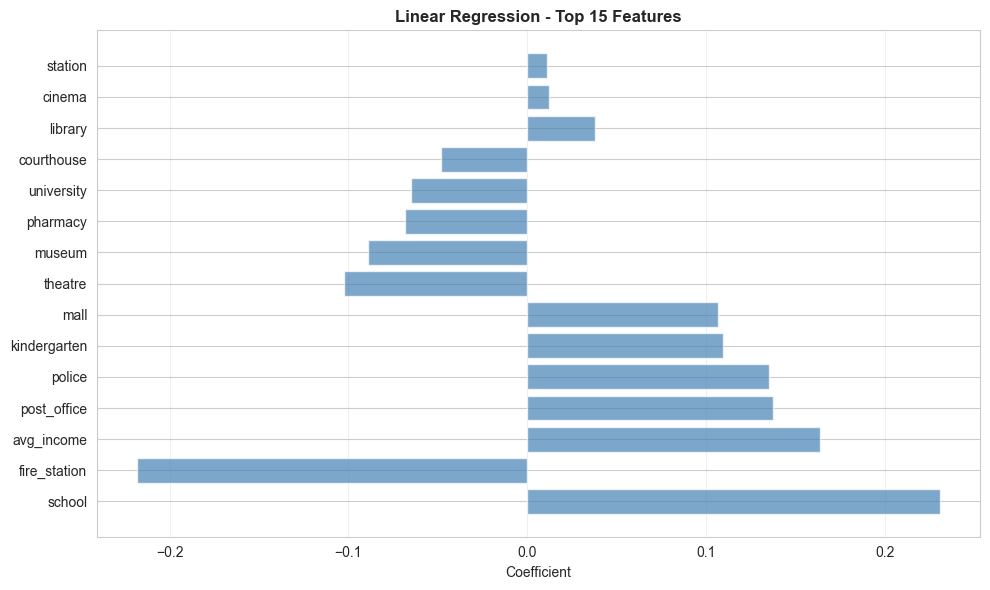

In [14]:
df = feature_importance_data["linear"].head(15)
col_name = "Coefficient"

plt.figure(figsize=(10, 6))
plt.barh(range(len(df)), df[col_name], color='steelblue', alpha=0.7)
plt.yticks(range(len(df)), df["Feature"])
plt.xlabel(col_name)
plt.title("Linear Regression - Top 15 Features", fontweight='bold')
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

In [15]:
df = feature_importance_data["linear"].head(15)
display(df.round(4))

,Feature,Coefficient
12,school,0.2309
3,fire_station,-0.2181
16,avg_income,0.1640
11,post_office,0.1375
10,police,0.1353
5,kindergarten,0.1094
7,mall,0.1067
14,theatre,-0.1023
8,museum,-0.0892
9,pharmacy,-0.0685


## Ridge Regression

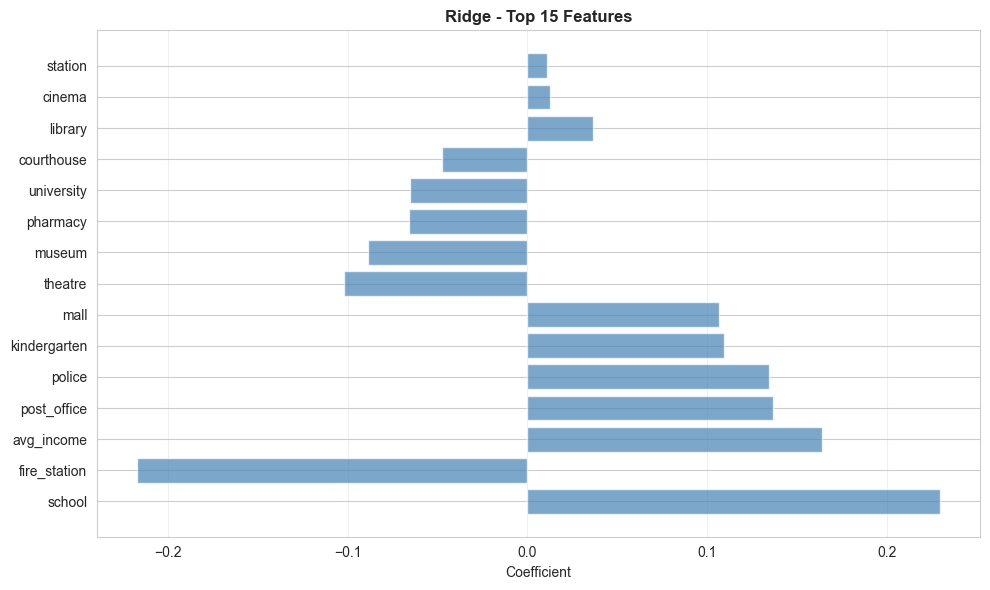

In [16]:
df = feature_importance_data["ridge"].head(15)
col_name = "Coefficient"

plt.figure(figsize=(10, 6))
plt.barh(range(len(df)), df[col_name], color='steelblue', alpha=0.7)
plt.yticks(range(len(df)), df["Feature"])
plt.xlabel(col_name)
plt.title("Ridge - Top 15 Features", fontweight='bold')
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

In [17]:
df = feature_importance_data["ridge"].head(15)
display(df.round(4))

,Feature,Coefficient
12,school,0.2296
3,fire_station,-0.2171
16,avg_income,0.1639
11,post_office,0.1369
10,police,0.1343
5,kindergarten,0.1094
7,mall,0.1066
14,theatre,-0.1019
8,museum,-0.0888
9,pharmacy,-0.0660


## Lasso Regression

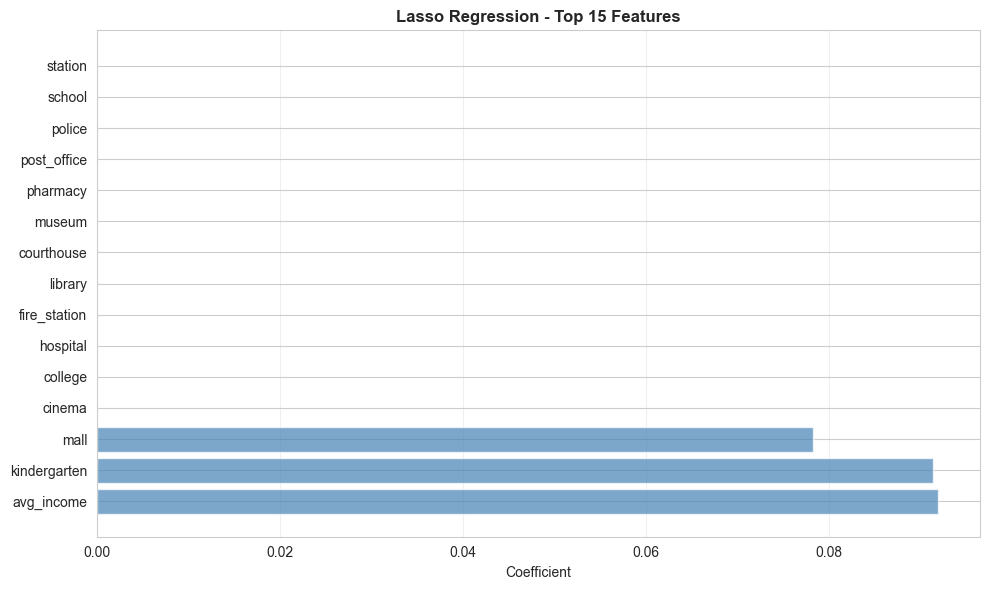

In [18]:
df = feature_importance_data["lasso"].head(15)
col_name = "Coefficient"

plt.figure(figsize=(10, 6))
plt.barh(range(len(df)), df[col_name], color='steelblue', alpha=0.7)
plt.yticks(range(len(df)), df["Feature"])
plt.xlabel(col_name)
plt.title("Lasso Regression - Top 15 Features", fontweight='bold')
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

In [19]:
df = feature_importance_data["lasso"].head(15)
display(df.round(4))

,Feature,Coefficient
16,avg_income,0.0919
5,kindergarten,0.0913
7,mall,0.0782
0,cinema,0.0000
1,college,0.0000
4,hospital,0.0000
3,fire_station,0.0000
6,library,0.0000
2,courthouse,0.0000
8,museum,0.0000


## ElasticNet

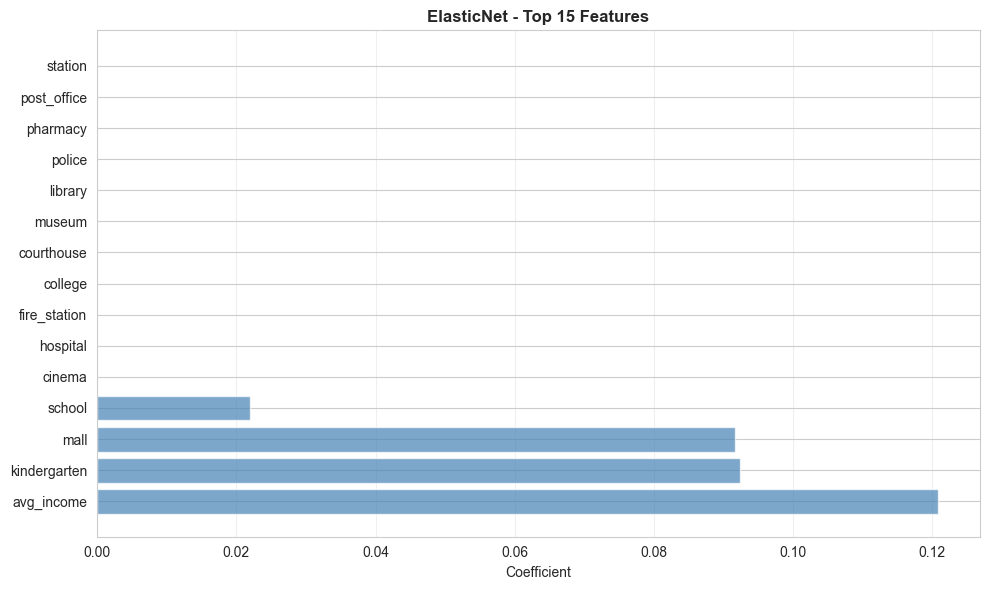

In [20]:
df = feature_importance_data["elasticnet"].head(15)
col_name = "Coefficient"

plt.figure(figsize=(10, 6))
plt.barh(range(len(df)), df[col_name], color='steelblue', alpha=0.7)
plt.yticks(range(len(df)), df["Feature"])
plt.xlabel(col_name)
plt.title("ElasticNet - Top 15 Features", fontweight='bold')
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

In [21]:
df = feature_importance_data["elasticnet"].head(15)
display(df.round(4))

,Feature,Coefficient
16,avg_income,0.1208
5,kindergarten,0.0923
7,mall,0.0916
12,school,0.0220
0,cinema,0.0000
4,hospital,0.0000
3,fire_station,-0.0000
1,college,-0.0000
2,courthouse,-0.0000
8,museum,-0.0000


## Gradient Boosting

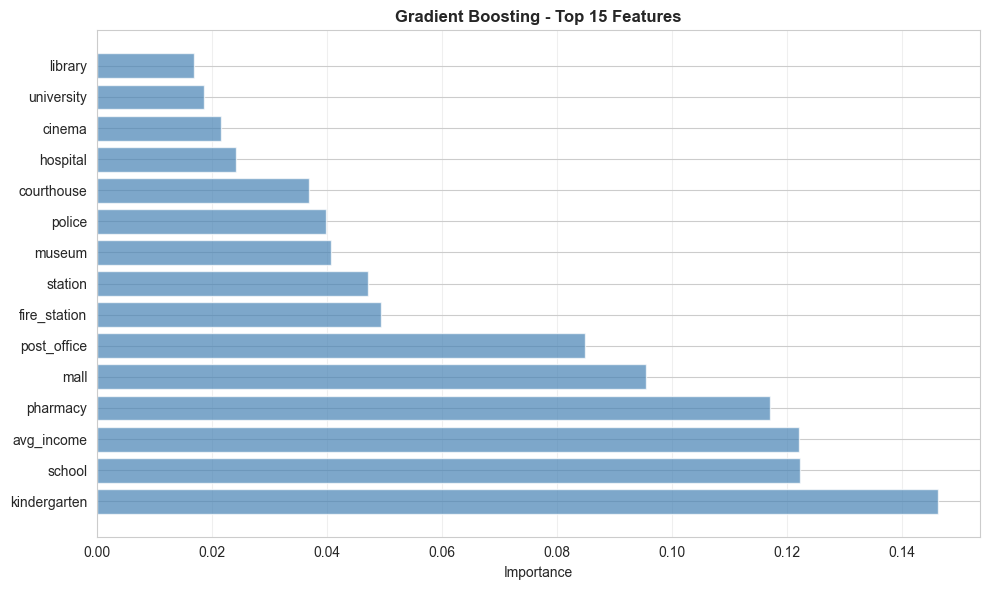

In [22]:
df = feature_importance_data["gbm"].head(15)
col_name = "Importance"

plt.figure(figsize=(10, 6))
plt.barh(range(len(df)), df[col_name], color='steelblue', alpha=0.7)
plt.yticks(range(len(df)), df["Feature"])
plt.xlabel(col_name)
plt.title("Gradient Boosting - Top 15 Features", fontweight='bold')
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

In [23]:
df = feature_importance_data["gbm"].head(15)
display(df.round(4))

,Feature,Importance
5,kindergarten,0.1462
12,school,0.1222
16,avg_income,0.1220
9,pharmacy,0.1170
7,mall,0.0954
11,post_office,0.0848
3,fire_station,0.0493
13,station,0.0470
8,museum,0.0407
10,police,0.0399


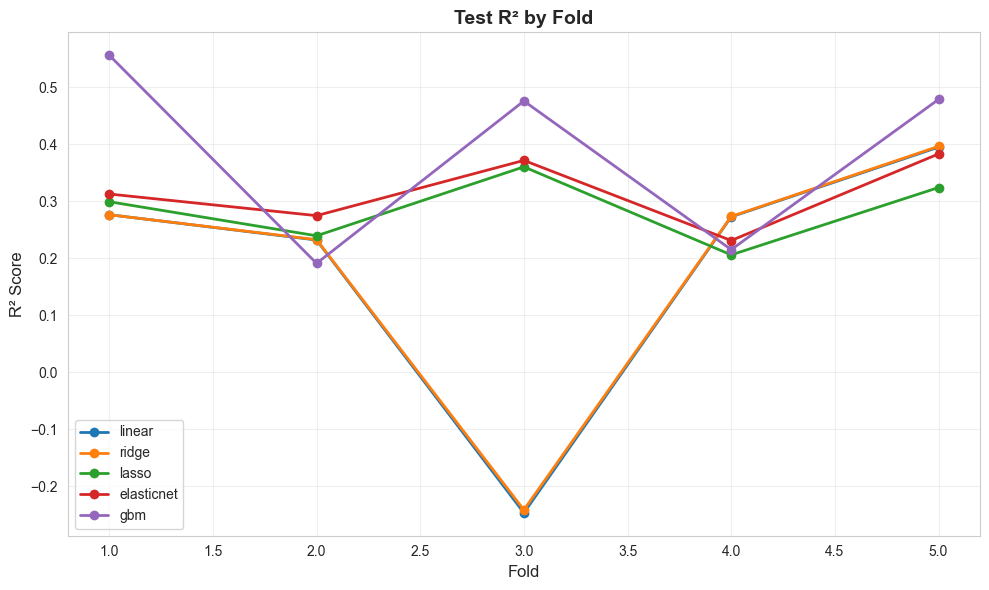

In [24]:
plt.figure(figsize=(10, 6))

for model_key in cv_results.keys():
    test_r2 = cv_results[model_key]["test_r2"]
    plt.plot(range(1, n_splits + 1), test_r2, marker='o', label=model_key, linewidth=2)

plt.xlabel("Fold", fontsize=12)
plt.ylabel("R² Score", fontsize=12)
plt.title("Test R² by Fold", fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [25]:
MODELS_DIR.mkdir(parents=True, exist_ok=True)

best_model_key = results_df.iloc[0]["Model"]
final_pipeline = trained_pipelines[best_model_key]

model_path = MODELS_DIR / f"{best_model_key}_final_model.joblib"
joblib.dump(final_pipeline, model_path)

results_path = MODELS_DIR / "cv_results.csv"
results_df.to_csv(results_path, index=False)


In [26]:
best_model_key = results_df.iloc[0]["Model"]
best_pipeline = trained_pipelines[best_model_key]

y_pred = best_pipeline.predict(X)
residuals = y - y_pred

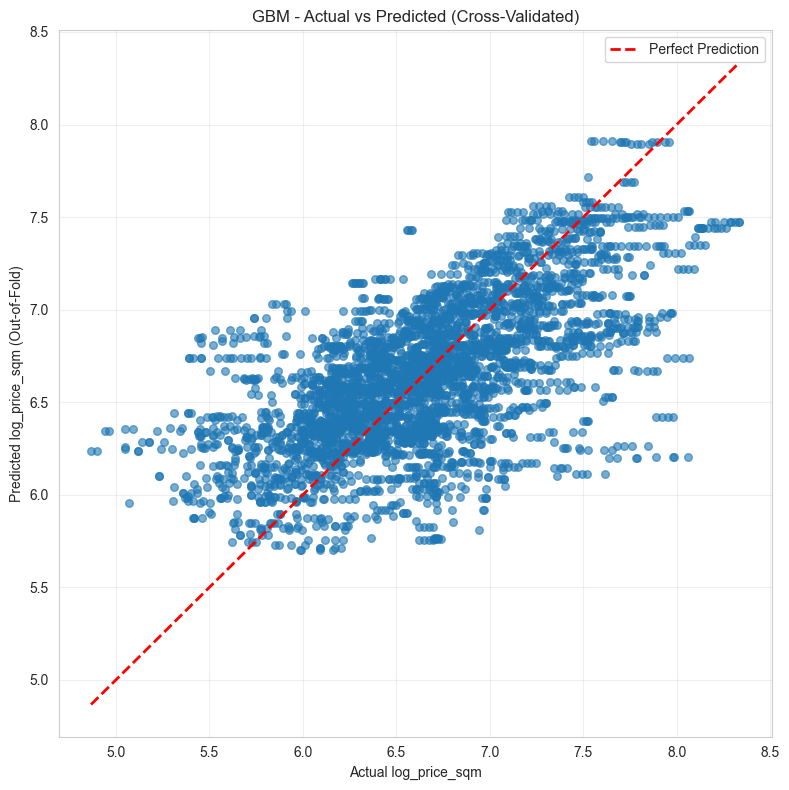

  R²: 0.4024
  RMSE: 0.4381
  MAE: 0.3337


In [27]:
best_model_key = results_df.iloc[0]["Model"]
best_config = model_configs[best_model_key]

best_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", best_config["class"](**best_config["params"])),
])

y_pred_cv = cross_val_predict(best_pipeline, X, y, cv=gkf, groups=groups, n_jobs=-1)

plt.figure(figsize=(8, 8))
plt.scatter(y, y_pred_cv, alpha=0.6, s=30)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', linewidth=2, label='Perfect Prediction')
plt.xlabel('Actual log_price_sqm')
plt.ylabel('Predicted log_price_sqm (Out-of-Fold)')
plt.title(f'{best_model_key.upper()} - Actual vs Predicted (Cross-Validated)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"  R²: {r2_score(y, y_pred_cv):.4f}")
print(f"  RMSE: {np.sqrt(mean_squared_error(y, y_pred_cv)):.4f}")
print(f"  MAE: {mean_absolute_error(y, y_pred_cv):.4f}")

In [28]:
df_train = df_master[df_master['year'] < 2023].copy()
df_test = df_master[df_master['year'] == 2023].copy()

print(f"Training samples: {len(df_train)}")
print(f"Test samples (2023): {len(df_test)}")

X_train = df_train[feature_cols].copy()
y_train = df_train[target_column].copy()
groups_train = df_train[MUNICIPALITY_COLUMN].values

X_test = df_test[feature_cols].copy()
y_test = df_test[target_column].copy()

valid_train = X_train.notna().all(axis=1) & y_train.notna()
X_train = X_train[valid_train].reset_index(drop=True)
y_train = y_train[valid_train].reset_index(drop=True)
groups_train = groups_train[valid_train]

valid_test = X_test.notna().all(axis=1) & y_test.notna()
X_test = X_test[valid_test].reset_index(drop=True)
y_test = y_test[valid_test].reset_index(drop=True)

Training samples: 3029
Test samples (2023): 932


In [29]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

cv_results = {}
test_results = {}
trained_pipelines = {}

gkf = GroupKFold(n_splits=5)
scoring = {"r2": "r2", "neg_mse": "neg_mean_squared_error", "neg_mae": "neg_mean_absolute_error"}

for model_key, config in model_configs.items():
    pipeline = Pipeline([
        ("preprocessor", preprocessor),
        ("regressor", config["class"](**config["params"])),
    ])

    cv_scores = cross_validate(
        pipeline, X_train, y_train, 
        cv=gkf, groups=groups_train, 
        scoring=scoring, return_train_score=True, n_jobs=-1
    )
    cv_results[model_key] = cv_scores

    pipeline.fit(X_train, y_train)
    trained_pipelines[model_key] = pipeline

    y_pred_test = pipeline.predict(X_test)

    test_results[model_key] = {
        'r2': r2_score(y_test, y_pred_test),
        'rmse': np.sqrt(mean_squared_error(y_test, y_pred_test)),
        'mae': mean_absolute_error(y_test, y_pred_test)
    }
    
    print(f"\n{model_key.upper()} - 2023 Test Performance:")
    print(f"  R²: {test_results[model_key]['r2']:.4f}")
    print(f"  RMSE: {test_results[model_key]['rmse']:.4f}")
    print(f"  MAE: {test_results[model_key]['mae']:.4f}")


LINEAR - 2023 Test Performance:
  R²: 0.3837
  RMSE: 0.4790
  MAE: 0.3694

RIDGE - 2023 Test Performance:
  R²: 0.3836
  RMSE: 0.4790
  MAE: 0.3694

LASSO - 2023 Test Performance:
  R²: 0.2586
  RMSE: 0.5253
  MAE: 0.4192

ELASTICNET - 2023 Test Performance:
  R²: 0.3035
  RMSE: 0.5092
  MAE: 0.4001

GBM - 2023 Test Performance:
  R²: 0.8526
  RMSE: 0.2342
  MAE: 0.1833


In [30]:
results_summary = []

for model_key in cv_results.keys():
    cv_scores = cv_results[model_key]
    test_perf = test_results[model_key]
    
    results_summary.append({
        "Model": model_key,
        "CV R² (2019-2022)": cv_scores["test_r2"].mean(),
        "CV R² Std": cv_scores["test_r2"].std(),
        "Test R² (2023)": test_perf['r2'],
        "CV RMSE": np.sqrt(-cv_scores["test_neg_mse"]).mean(),
        "Test RMSE (2023)": test_perf['rmse'],
        "CV MAE": (-cv_scores["test_neg_mae"]).mean(),
        "Test MAE (2023)": test_perf['mae']
    })

results_df = pd.DataFrame(results_summary).sort_values("Test R² (2023)", ascending=False)
display(results_df.round(4))

results_path = MODELS_DIR / "temporal_validation_results.csv"
results_df.to_csv(results_path, index=False)
print(f"\nResults saved to {results_path}")

,Model,CV R² (2019-2022),CV R² Std,Test R² (2023),CV RMSE,Test RMSE (2023),CV MAE,Test MAE (2023)
4,gbm,0.3217,0.1780,0.8526,0.4405,0.2342,0.3378,0.1833
0,linear,0.1957,0.1956,0.3837,0.4848,0.4790,0.3649,0.3694
1,ridge,0.1976,0.1938,0.3836,0.4843,0.4790,0.3646,0.3694
3,elasticnet,0.3118,0.0601,0.3035,0.4479,0.5092,0.3460,0.4001
2,lasso,0.2809,0.0579,0.2586,0.4580,0.5253,0.3550,0.4192



Results saved to C:\Users\gonca\Desktop\asdf\FCD-housing-prices\models\temporal_validation_results.csv


GBM with Random Split:
  R²: 0.9280
  RMSE: 0.1531
  MAE: 0.1082


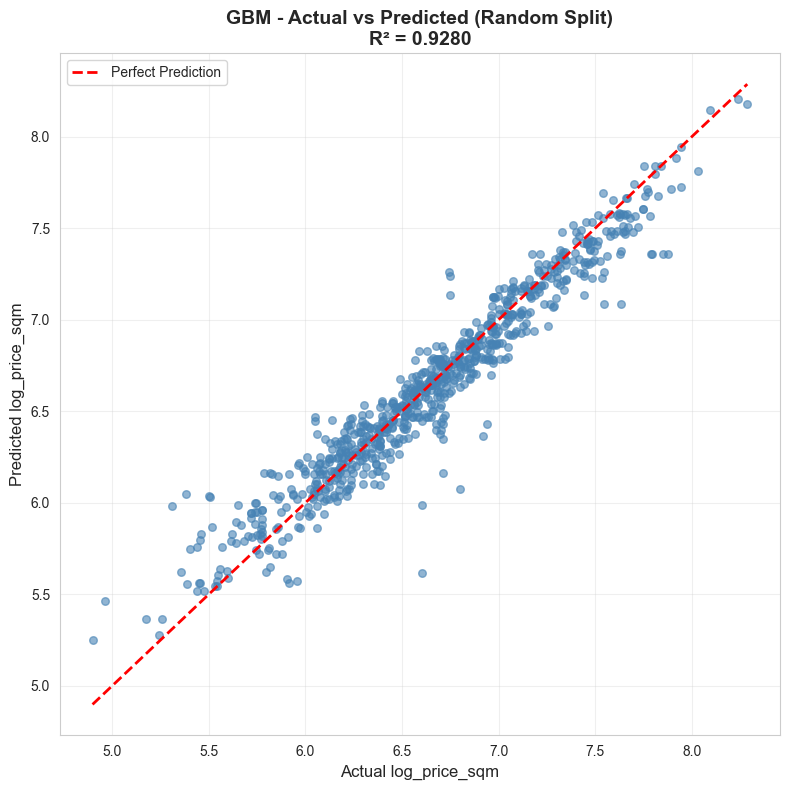

In [31]:
from sklearn.model_selection import train_test_split

X_random_train, X_random_test, y_random_train, y_random_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED
)

gbm_pipeline_random = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", GradientBoostingRegressor(**model_configs["gbm"]["params"])),
])

gbm_pipeline_random.fit(X_random_train, y_random_train)

y_pred_random = gbm_pipeline_random.predict(X_random_test)

r2_random = r2_score(y_random_test, y_pred_random)
rmse_random = np.sqrt(mean_squared_error(y_random_test, y_pred_random))
mae_random = mean_absolute_error(y_random_test, y_pred_random)

print(f"GBM with Random Split:")
print(f"  R²: {r2_random:.4f}")
print(f"  RMSE: {rmse_random:.4f}")
print(f"  MAE: {mae_random:.4f}")

plt.figure(figsize=(8, 8))
plt.scatter(y_random_test, y_pred_random, alpha=0.6, s=30, color='steelblue')
plt.plot([y_random_test.min(), y_random_test.max()], [y_random_test.min(), y_random_test.max()], 
         'r--', linewidth=2, label='Perfect Prediction')
plt.xlabel('Actual log_price_sqm', fontsize=12)
plt.ylabel('Predicted log_price_sqm', fontsize=12)
plt.title(f'GBM - Actual vs Predicted (Random Split)\nR² = {r2_random:.4f}', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()